In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
import numpy as np
import matplotlib.pyplot as plt

## Autoencoder Class

In [9]:
class DualDecoderAutoencoder(nn.Module):
    def __init__(self):
        super(DualDecoderAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # [B, 3, 32, 32] -> [B, 64, 16, 16]
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # [B, 64, 16, 16] -> [B, 128, 8, 8]
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # [B, 128, 8, 8] -> [B, 256, 4, 4]
            nn.ReLU(True),
            nn.Flatten(), # [B, 256, 4, 4] -> [B, 256*4*4]
            nn.Linear(256*4*4, 512),  # [B, 256*4*4] -> [B, 512]
            nn.ReLU(True)
        )
        
        # Decoder for MNIST
        self.decoder_mnist = nn.Sequential(
            nn.Linear(512, 256*4*4),  # [B, 512] -> [B, 256*4*4]
            nn.ReLU(True),
            nn.Unflatten(1, (256, 4, 4)),  # [B, 256*4*4] -> [B, 256, 4, 4]
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # [B, 256, 4, 4] -> [B, 128, 8, 8]
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # [B, 128, 8, 8] -> [B, 64, 16, 16]
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # [B, 64, 16, 16] -> [B, 3, 32, 32]
            nn.Sigmoid()  # Sigmoid to output values between 0 and 1 for MNIST
        )
        
        # Decoder for CIFAR-10
        self.decoder_cifar = nn.Sequential(
            nn.Linear(512, 256*4*4),  # [B, 512] -> [B, 256*4*4]
            nn.ReLU(True),
            nn.Unflatten(1, (256, 4, 4)),  # [B, 256*4*4] -> [B, 256, 4, 4]
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # [B, 256, 4, 4] -> [B, 128, 8, 8]
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # [B, 128, 8, 8] -> [B, 64, 16, 16]
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # [B, 64, 16, 16] -> [B, 3, 32, 32]
            nn.Sigmoid()  # Sigmoid to output values between 0 and 1 for CIFAR-10
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded_mnist = self.decoder_mnist(encoded)
        decoded_cifar = self.decoder_cifar(encoded)
        return decoded_mnist, decoded_cifar


In [10]:
# Instantiate the model, loss function, and optimizer
autoencoder = DualDecoderAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)


In [11]:
transform_mnist = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize MNIST images to match CIFAR-10 shape
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1))  # Expand the single channel to make it three channels
])

transform_cifar = transforms.Compose([
    transforms.ToTensor()
])

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)

batch_size = 64

# DataLoader
mnist_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)
cifar_loader = torch.utils.data.DataLoader(cifar_dataset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified


## Training Loop

In [12]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for (mnist_images, _), (cifar_images, _) in zip(mnist_loader, cifar_loader):
        if mnist_images.size(0) != cifar_images.size(0):
            continue  
        mean_images = (mnist_images + cifar_images) / 2
        
        # Forward pass
        reconstructed_mnist, reconstructed_cifar = autoencoder(mean_images)
        
        # Compute loss
        loss_mnist = criterion(reconstructed_mnist, mnist_images)
        loss_cifar = criterion(reconstructed_cifar, cifar_images)
        loss = loss_mnist + loss_cifar
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 0.0354
Epoch [2/10], Loss: 0.0256
Epoch [3/10], Loss: 0.0224
Epoch [4/10], Loss: 0.0199
Epoch [5/10], Loss: 0.0165
Epoch [6/10], Loss: 0.0145
Epoch [7/10], Loss: 0.0158
Epoch [8/10], Loss: 0.0139
Epoch [9/10], Loss: 0.0133
Epoch [10/10], Loss: 0.0118


Reconstructed MNIST Image shape: torch.Size([1, 3, 32, 32])
Reconstructed CIFAR-10 Image shape: torch.Size([1, 3, 32, 32])
Original MNIST Image:


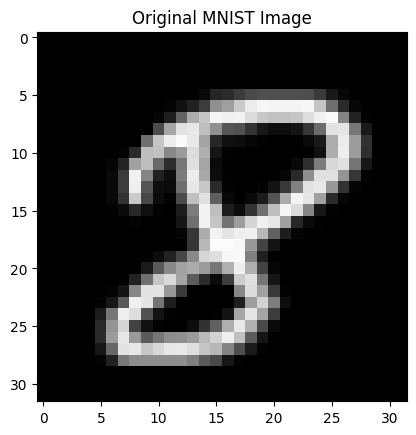

Original CIFAR-10 Image:


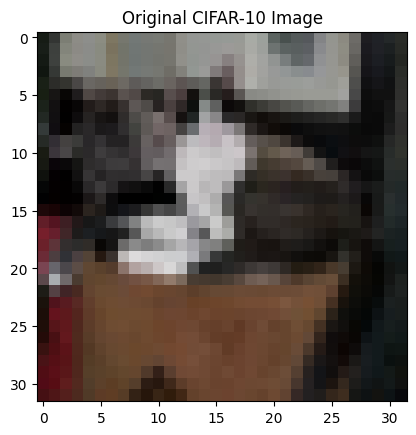

Mean Image:


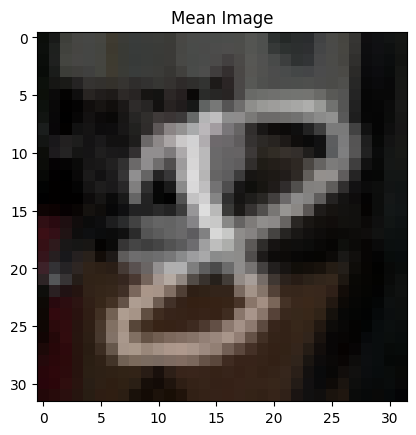

Reconstructed MNIST Image:


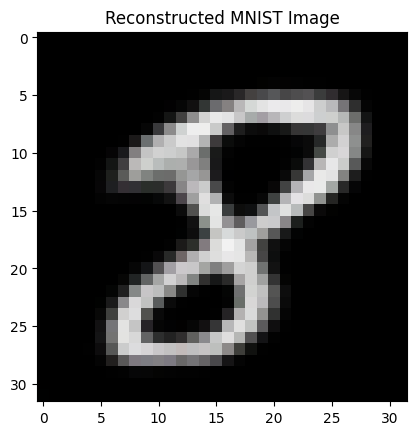

Reconstructed CIFAR-10 Image:


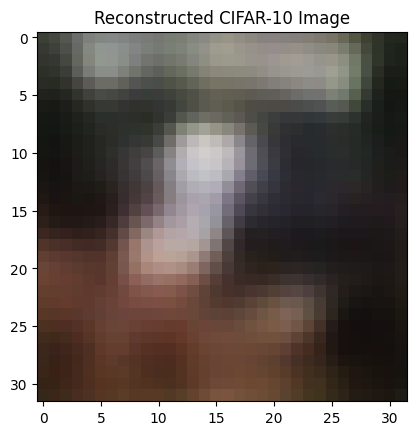

In [13]:
def imshow(img, title=None):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

# Get random images
def get_random_images(mnist_dataset, cifar_dataset):
    mnist_image, _ = mnist_dataset[np.random.randint(len(mnist_dataset))]
    cifar_image, _ = cifar_dataset[np.random.randint(len(cifar_dataset))]
    return mnist_image, cifar_image

mnist_image, cifar_image = get_random_images(mnist_dataset, cifar_dataset)

# Compute the mean image
mean_image = (mnist_image + cifar_image) / 2

mean_image_input = mean_image.unsqueeze(0)  # Add batch dimension

with torch.no_grad():
    reconstructed_mnist, reconstructed_cifar = autoencoder(mean_image_input)

print("Reconstructed MNIST Image shape:", reconstructed_mnist.shape)
print("Reconstructed CIFAR-10 Image shape:", reconstructed_cifar.shape)

reconstructed_mnist = reconstructed_mnist.squeeze(0)
reconstructed_cifar = reconstructed_cifar.squeeze(0)

# Display the original images
print("Original MNIST Image:")
imshow(mnist_image, "Original MNIST Image")

print("Original CIFAR-10 Image:")
imshow(cifar_image, "Original CIFAR-10 Image")

# Display the mean image and its reconstruction
print("Mean Image:")
imshow(mean_image, "Mean Image")

print("Reconstructed MNIST Image:")
imshow(reconstructed_mnist, "Reconstructed MNIST Image")

print("Reconstructed CIFAR-10 Image:")
imshow(reconstructed_cifar, "Reconstructed CIFAR-10 Image")


## Compute SSIM and PSNR

In [14]:
# Convert images to numpy arrays for SSIM and PSNR computation
original_mnist_np = mnist_image.numpy()
original_cifar_np = cifar_image.numpy()
reconstructed_mnist_np = reconstructed_mnist.numpy()
reconstructed_cifar_np = reconstructed_cifar.numpy()

# Compute SSIM and PSNR
ssim_mnist = ssim(original_mnist_np.transpose(1, 2, 0), reconstructed_mnist_np.transpose(1, 2, 0), win_size=3, channel_axis=-1, data_range=1)
ssim_cifar = ssim(original_cifar_np.transpose(1, 2, 0), reconstructed_cifar_np.transpose(1, 2, 0), win_size=3, channel_axis=-1, data_range=1)
psnr_mnist = psnr(original_mnist_np, reconstructed_mnist_np, data_range=1)
psnr_cifar = psnr(original_cifar_np, reconstructed_cifar_np, data_range=1)

print(f"SSIM (MNIST): {ssim_mnist:.4f}")
print(f"SSIM (CIFAR-10): {ssim_cifar:.4f}")
print(f"PSNR (MNIST): {psnr_mnist:.2f} dB")
print(f"PSNR (CIFAR-10): {psnr_cifar:.2f} dB")


SSIM (MNIST): 0.8929
SSIM (CIFAR-10): 0.4427
PSNR (MNIST): 21.55 dB
PSNR (CIFAR-10): 20.12 dB
